* [pytorch tutorials](https://pytorch.org/tutorials/)
* [torchaudio](https://pytorch.org/audio/stable/index.html)

In [1]:
# %%bash
!pip install torch==1.12.1
!pip install torchaudio==0.12.1
!pip install omegaconf==2.2.3
!pip install --upgrade git+https://github.com/Lyken17/pytorch-OpCounter.git

# mkdir ./data
# wget -q https://raw.githubusercontent.com/karpnv/speech-tech-mipt/week5/week05/data/8b427e83c196b517cd240822a18ba698.wav -P ./data

  Cloning https://github.com/Lyken17/pytorch-OpCounter.git to /private/var/folders/vc/ncyx6pz567x9w9jb_lsmyjgm0000gn/T/pip-req-build-aczprgjc
  Running command git clone --filter=blob:none -q https://github.com/Lyken17/pytorch-OpCounter.git /private/var/folders/vc/ncyx6pz567x9w9jb_lsmyjgm0000gn/T/pip-req-build-aczprgjc
  Resolved https://github.com/Lyken17/pytorch-OpCounter.git to commit 43c064afb71383501e41eaef9e8c8407265cf77f
  Preparing metadata (setup.py) ... done
  Created wheel for thop: filename=thop-0.1.1.post2212161214-py3-none-any.whl size=15465 sha256=41cfdc013e9f3da5356170392e60bffd47813d951cd267601b861a4b0c8babe2
  Stored in directory: /private/var/folders/vc/ncyx6pz567x9w9jb_lsmyjgm0000gn/T/pip-ephem-wheel-cache-uqvw4d61/wheels/a3/0f/f1/a1ae62b0001ebe2151f896da752b9fb5198bf3b5427603de0e
Successfully built thop
  Attempting uninstall: thop
    Found existing installation: thop 0.1.1.post2212161208
    Uninstalling thop-0.1.1.post2212161208:
      Successfully uninstalled t

In [1]:
import random
import logging
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from typing import Optional, Callable, Dict, List, Any, Tuple

import omegaconf
import torch
from torch.utils.tensorboard import SummaryWriter
import torchaudio
import thop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import IPython.display as ipd

logging.basicConfig(
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', level=logging.INFO
)
logger = logging.getLogger('Training process')

In [2]:
SEED = 777

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
@dataclass
class Model:
    kernels: Tuple[int]
    strides: Tuple[int]
    channels: Tuple[int]
    hidden_size: int
    activation: str

@dataclass
class Optim:
    lr: float
    n_epochs: int
    batch_size: int
        
@dataclass
class Features:
    n_fft: int
    win_length: int
    hop_length: int
    n_mels: int

@dataclass
class Augmentations:
    freq_mask_param: int
    time_mask_param: int

In [4]:
@dataclass
class ExpConfig:
    sample_rate: int = 16_000
    val_fraction: float = 0.1
    idx_to_keyword: List[str] = ('sber', 'joy', 'afina', 'salut', 'filler')
    device: str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
    model: Model = Model(
        kernels=(3, 3), strides=(2, 2), channels=(32, 32), hidden_size=16, activation='ReLU'
    )
    optim: Optim = Optim(
        lr=1e-3, n_epochs=10, batch_size=64
    )
    features: Features = Features(
        n_fft=400, win_length=400, hop_length=160, n_mels=64
    )
    augs: Augmentations = Augmentations(
        freq_mask_param=0, time_mask_param=0
    )

In [5]:
conf = omegaconf.OmegaConf.structured(ExpConfig)

# Data

download from [kaggle](https://www.kaggle.com/t/830d20b353bd4e0d80630a97835f14a6)

# Dataset

In [6]:
class SpecScaler(torch.nn.Module):
    def forward(self, x):
        return torch.log(x.clamp_(1e-9, 1e9))

In [7]:
class SpotterDataset(torch.utils.data.Dataset):
    
    def __init__(
            self, manifest_path: Path, idx_to_keyword: List[str],
            transform, ids: Optional[List[int]] = None
        ):
        super().__init__()
        
        self.transform = transform
        
        manifest = pd.read_csv(manifest_path)
        if ids is not None:
            manifest = manifest.loc[ids]
        self.wav_files = [
            manifest_path.parent / wav_path for wav_path in manifest.path
        ]
        
        keyword_to_idx = {
            keyword: idx for idx, keyword in enumerate(idx_to_keyword)
        }
        self.labels = [
            keyword_to_idx[keyword] for keyword in manifest.label
        ]
        
    def __len__(self):
        return len(self.wav_files)
    
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.wav_files[idx])
        features = self.transform(wav)
        return wav[0], features, self.labels[idx]

In [8]:
dataset = SpotterDataset(
    manifest_path=Path("train/train/manifest.csv"),
    idx_to_keyword=conf.idx_to_keyword,
    transform=torch.nn.Sequential(
        torchaudio.transforms.MelSpectrogram(sample_rate=conf.sample_rate, **conf.features),
        torchaudio.transforms.FrequencyMasking(freq_mask_param=conf.augs.freq_mask_param),
        torchaudio.transforms.TimeMasking(time_mask_param=conf.augs.time_mask_param),
        SpecScaler()
    )
)

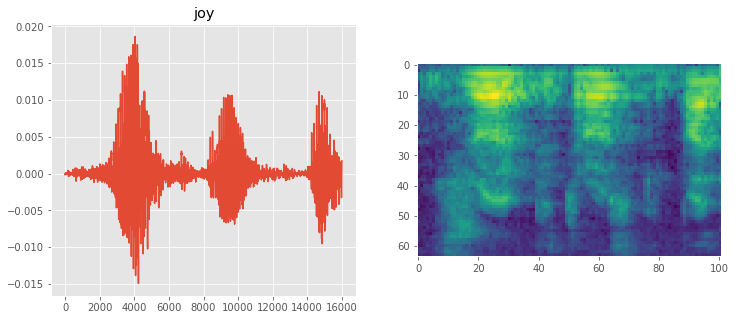

In [9]:
wav, features, label = next(iter(dataset))

ipd.display(ipd.Audio(wav, rate=conf.sample_rate))
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title(conf.idx_to_keyword[label])
plt.plot(wav)
plt.subplot(122)
plt.grid()
plt.imshow(features[0])
plt.show()

In [10]:
def collator(data):
    specs = []
    labels = []

    for wav, features, label in data:
        specs.append(features)
        labels.append(label)

    specs = torch.cat(specs)  
    labels = torch.Tensor(labels).long()
    return specs, labels

# Train Loop

In [11]:
def train_one_epoch(model, criterion, optimizer, loader, device, epoch_index, tb_writer, log_interval=100):
    
    model.train()
    
    running_loss = 0.
    running_true_preds, running_preds = 0, 0
    last_loss, last_acc = 0., 0.

    for i, (inputs, labels) in enumerate(loader):
        
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logprobs = model(inputs)
        preds = logprobs.argmax(1)
        loss = criterion(logprobs, labels)
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item()
        running_true_preds += (preds == labels).sum()
        running_preds += torch.numel(preds)
        
        if i % log_interval == log_interval - 1:
            last_loss = running_loss / log_interval
            last_acc = running_true_preds / running_preds 
            tb_x = epoch_index * len(loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            tb_writer.add_scalar('Accuracy/train', last_acc, tb_x)
            running_loss = 0.
            running_true_preds, running_preds = 0, 0

    return last_loss, last_acc


@torch.no_grad()
def validation(model, criterion, loader, device, epoch_index, tb_writer):
    
    model.eval()
    
    running_loss = 0.
    running_true_preds, running_preds = 0, 0

    for i, (inputs, labels) in enumerate(loader):
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        logprobs = model(inputs)
        preds = logprobs.argmax(1)
        
        running_loss += criterion(logprobs, labels).item()
        running_true_preds += (preds == labels).sum()
        running_preds += torch.numel(preds)
        
    loss = running_loss / len(loader)
    acc = running_true_preds / running_preds 
    
    tb_x = epoch_index + 1
    tb_writer.add_scalar('Loss/val', loss, tb_x)
    tb_writer.add_scalar('Accuracy/val', acc, tb_x)
    
    return loss, acc

# Model

In [12]:
class Model2dConv(torch.nn.Module):
    
    def __init__(self, in_features, n_classes, conf: omegaconf.dictconfig.DictConfig):
        
        super().__init__()
        
        activation = getattr(torch.nn, conf.activation)()
        self.module_list = []    

        # *********************************************
        self.module_list.extend([
                torch.nn.Conv2d(in_channels=1, 
                                out_channels=16, 
                                kernel_size=(3,3), 
                                groups=1),
                activation,
                torch.nn.Conv2d(in_channels=16, 
                                out_channels=16, 
                                kernel_size=1),
                torch.nn.BatchNorm2d(num_features=16),
                activation,
                torch.nn.MaxPool2d(kernel_size=3),
                torch.nn.Conv2d(in_channels=16, 
                                out_channels=32, 
                                kernel_size=(3,3), 
                                groups=1),
                activation,
                torch.nn.Conv2d(in_channels=32, 
                                out_channels=32, 
                                kernel_size=1),
                torch.nn.BatchNorm2d(num_features=32),
                activation,
                torch.nn.MaxPool2d(kernel_size=3),
                torch.nn.Conv2d(in_channels=32, 
                                out_channels=64, 
                                kernel_size=(3,3), 
                                groups=1),
                activation,
                torch.nn.Conv2d(in_channels=64, 
                                out_channels=64, 
                                kernel_size=1),
                torch.nn.BatchNorm2d(num_features=64),
                activation,
                torch.nn.MaxPool2d(kernel_size=4),
            # ----
                torch.nn.Flatten(),
                torch.nn.Linear(128, 64),
                torch.nn.BatchNorm1d(num_features=64),
                activation,
                torch.nn.Dropout(0.2),
                torch.nn.Linear(64, n_classes),
                torch.nn.LogSoftmax(-1)])
        # *********************************************
        self.model = torch.nn.Sequential(*self.module_list)
        
    def forward(self, x):
        return self.model(x.unsqueeze(dim=1))

In [13]:
model = Model2dConv(
    in_features=conf.features.n_mels, 
    n_classes=len(conf.idx_to_keyword),
    conf=conf.model
)

In [14]:
thop.profile(
    model, inputs=(torch.randn(1, 64, 101),)
)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


(6799968.0, 37717.0)

#### Experiments

In [15]:
@dataclass
class ExpConfig:
    sample_rate: int = 16_000
    val_fraction: float = 0.1
    idx_to_keyword: List[str] = ('sber', 'joy', 'afina', 'salut', 'filler')
    device: str = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    
    model: Model = Model(
        kernels=(3, 3), strides=(2, 2), channels=(32, 32), hidden_size=16, activation='ReLU'
    )
    optim: Optim = Optim(
        lr=1e-3, n_epochs=10, batch_size=64
    )
    features: Features = Features(
        n_fft=400, win_length=400, hop_length=160, n_mels=64
    )
    augs: Augmentations = Augmentations(
        freq_mask_param=0, time_mask_param=0
    )

In [16]:
conf = omegaconf.OmegaConf.structured(ExpConfig)

In [17]:
train_transform = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=conf.sample_rate, **conf.features),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=conf.augs.freq_mask_param),
    torchaudio.transforms.TimeMasking(time_mask_param=conf.augs.time_mask_param),
    SpecScaler()
)

val_transform = torch.nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=conf.sample_rate, **conf.features),
    SpecScaler()
)

In [18]:
val_count = int(len(dataset) * conf.val_fraction)
ids = torch.randperm(len(dataset), generator=torch.Generator().manual_seed(SEED))

val_ids = ids[:val_count]
train_ids = ids[val_count:]

train_dataset = SpotterDataset(
    manifest_path=Path("train/train/manifest.csv"),
    idx_to_keyword=conf.idx_to_keyword,
    transform=train_transform,
    ids=train_ids
)

val_dataset = SpotterDataset(
    manifest_path=Path("train/train/manifest.csv"),
    idx_to_keyword=conf.idx_to_keyword,
    transform=val_transform,
    ids=val_ids
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=conf.optim.batch_size,
    shuffle=False,
    collate_fn=collator
)

val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=conf.optim.batch_size,
    shuffle=False,
    collate_fn=collator
)

In [19]:
model = (
    Model2dConv(
        in_features=conf.features.n_mels, 
        n_classes=len(conf.idx_to_keyword),
        conf=conf.model
    )
    .to(conf.device)
)
optimizer = torch.optim.Adam(params=model.parameters(), lr=conf.optim.lr)
criterion = torch.nn.NLLLoss()

macs, params = thop.profile(
    model, inputs=(
        torch.randn(1, conf.features.n_mels, conf.sample_rate // conf.features.hop_length + 1)
        .to(conf.device)
        ,
    )
)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm1d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.


In [20]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

exp_dir = Path(f"runs/{timestamp}")
ckpt_dir = exp_dir / "ckpts"
ckpt_dir.mkdir(parents=True)
with open(exp_dir / 'conf.yaml', 'w') as f:
    omegaconf.OmegaConf.save(config=conf, f=f)

tb_writer = SummaryWriter(exp_dir)

tb_writer.add_scalar('MACs', macs, 0)
tb_writer.add_scalar('Params', params, 0)

best_val_acc = -1.

In [21]:
# !rm -r '/content/runs/'

In [22]:
val_acc_ = []
tr_acc_ = []

for epoch in range(0,10):
    
    logger.info(f'Training {epoch + 1} epoch...')

    avg_loss, avg_acc  = train_one_epoch(
        model, criterion, optimizer, train_dataloader,
        conf.device, epoch, tb_writer
    )
    logger.info(f'Validating {epoch + 1} epoch...')
    val_loss, val_acc = validation(
        model, criterion, val_dataloader,
        conf.device, epoch, tb_writer
    )
    logger.info(f'Avg_loss {avg_loss}, Val_loss {val_loss}')
    logger.info(f'Avg_acc {avg_acc}, Val_acc {val_acc}')
    val_acc_.append(val_acc)
    tr_acc_.append(avg_acc)
    logger.info(f'Done training {epoch + 1} epoch')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            model.state_dict(),
            ckpt_dir / f"model_epoch_{epoch + 1}_val_acc_{val_acc:.3f}.ckpt")

2022-12-16 17:02:50,466 - Training process - INFO - Training 1 epoch...
2022-12-16 17:08:24,058 - Training process - INFO - Validating 1 epoch...
2022-12-16 17:08:45,440 - Training process - INFO - Avg_loss 0.4249067406356335, Val_loss 0.39305383813451733
2022-12-16 17:08:45,443 - Training process - INFO - Avg_acc 0.8467187285423279, Val_acc 0.8544327020645142
2022-12-16 17:08:45,443 - Training process - INFO - Done training 1 epoch
2022-12-16 17:08:45,464 - Training process - INFO - Training 2 epoch...
2022-12-16 17:14:14,642 - Training process - INFO - Validating 2 epoch...
2022-12-16 17:14:34,770 - Training process - INFO - Avg_loss 0.3783654783666134, Val_loss 0.35709763322708876
2022-12-16 17:14:34,771 - Training process - INFO - Avg_acc 0.862500011920929, Val_acc 0.8647047877311707
2022-12-16 17:14:34,772 - Training process - INFO - Done training 2 epoch
2022-12-16 17:14:34,783 - Training process - INFO - Training 3 epoch...
2022-12-16 17:20:20,422 - Training process - INFO - Val

In [27]:
val_acc_

[tensor(0.8544),
 tensor(0.8647),
 tensor(0.8718),
 tensor(0.8647),
 tensor(0.8716),
 tensor(0.8801),
 tensor(0.8766),
 tensor(0.8840),
 tensor(0.8796),
 tensor(0.8806)]

# Submit

In [23]:
class TestSpotterDataset(torch.utils.data.Dataset):
    def __init__(self, manifest_path: Path, transform):
        super().__init__()
        
        self.transform = transform
        manifest = pd.read_csv(manifest_path)
        self.wav_files = [
            manifest_path.parent / wav_path for wav_path in manifest.path
        ]
        self.labels = manifest.index.values
        
    def __len__(self):
        return len(self.wav_files)
    
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.wav_files[idx])
        features = self.transform(wav)
        return wav[0], features, self.labels[idx]

In [24]:
model.eval()

test_dataloader = torch.utils.data.DataLoader(
    dataset=TestSpotterDataset(
        manifest_path=Path('test/test/manifest.csv'),
        transform=val_transform
    ),
    collate_fn=collator,
    batch_size=conf.optim.batch_size,
    shuffle=False
)

In [25]:
index_lst, label_lst = [], []

for inputs, idx in test_dataloader:
    
    with torch.no_grad():
        preds = model(inputs.to(conf.device)).argmax(-1).cpu().tolist()
    
    label_lst.extend([conf.idx_to_keyword[idx] for idx in preds])
    index_lst.extend(idx.tolist())

In [26]:
(
    pd.DataFrame({'index': index_lst, 'label': label_lst})
    .to_csv('final.csv', index=False)
)